In [1]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANDL/Homework_1

Mounted at /gdrive
/gdrive/My Drive/ANDL/Homework_1


In [2]:
#!unzip atMost700.zip

In [3]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
# Dataset folders 
dataset_dir = 'atMost700'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8',]

Text(0.5, 1.0, 'Number of training images per category:')

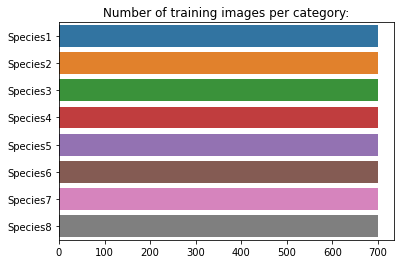

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=180,
                                        height_shift_range=48,
                                        width_shift_range=48,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        brightness_range=(0.2, 0.8),  
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. not on vgg16
                                        ) 
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

In [9]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 5600 images belonging to 8 classes.
Found 527 images belonging to 8 classes.
Found 361 images belonging to 8 classes.


In [10]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (32, 96, 96, 3)
Target shape: (32, 8)

Categorical label: [0. 0. 0. 0. 0. 0. 1. 0.]
Label: 6
Class name: Species7


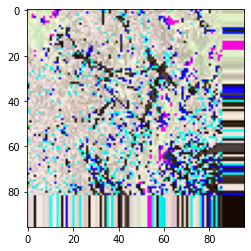

In [11]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

In [12]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

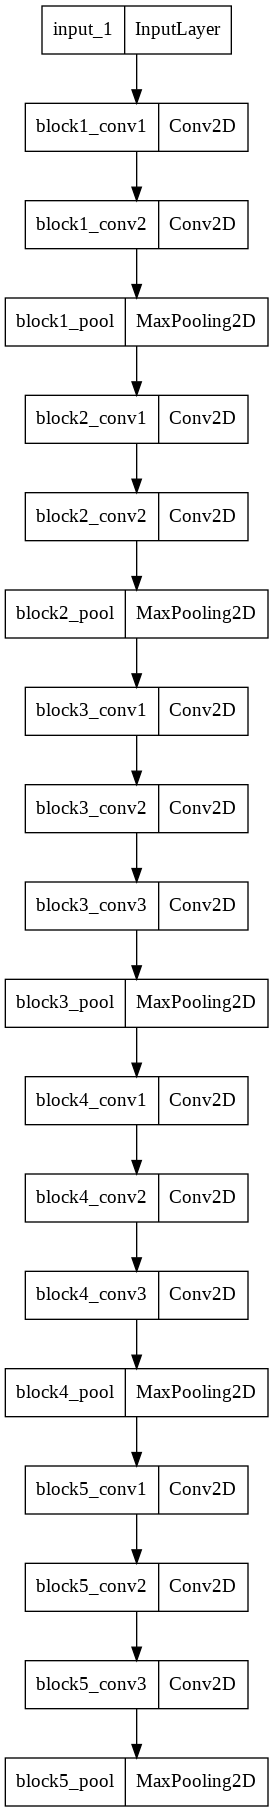

In [13]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [14]:
input_shape = (96, 96, 3)
epochs = 200

In [15]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
# No resize
#x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [16]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [17]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = tl_callbacks,
    #class_weight=class_weight
).history

Epoch 1/200
175/175 [==============================] - ETA: 0s - loss: 4.4513 - accuracy: 0.2279 - precision: 0.2694 - recall: 0.1039

175/175 [==============================] - 1287s 7s/step - loss: 4.4513 - accuracy: 0.2279 - precision: 0.2694 - recall: 0.1039 - val_loss: 1.8589 - val_accuracy: 0.3283 - val_precision: 0.4526 - val_recall: 0.1992
Epoch 2/200
175/175 [==============================] - ETA: 0s - loss: 1.8789 - accuracy: 0.2634 - precision: 0.4581 - recall: 0.0654

175/175 [==============================] - 35s 198ms/step - loss: 1.8789 - accuracy: 0.2634 - precision: 0.4581 - recall: 0.0654 - val_loss: 1.6257 - val_accuracy: 0.3454 - val_precision: 0.5147 - val_recall: 0.1992
Epoch 3/200
175/175 [==============================] - ETA: 0s - loss: 1.7365 - accuracy: 0.2995 - precision: 0.4774 - recall: 0.0773

175/175 [==============================] - 33s 188ms/step - loss: 1.7365 - accuracy: 0.2995 - precision: 0.4774 - recall: 0.0773 - val_loss: 1.8470 - val_accuracy: 0.3643 - val_precision: 0.4824 - val_recall: 0.2600
Epoch 4/200
175/175 [==============================] - ETA: 0s - loss: 1.6846 - accuracy: 0.3157 - precision: 0.5391 - recall: 0.0898

175/175 [==============================] - 34s 195ms/step - loss: 1.6846 - accuracy: 0.3157 - precision: 0.5391 - recall: 0.0898 - val_loss: 1.5294 - val_accuracy: 0.3757 - val_precision: 0.5403 - val_recall: 0.2543
Epoch 5/200
175/175 [==============================] - ETA: 0s - loss: 1.6518 - accuracy: 0.3389 - precision: 0.5500 - recall: 0.1111

175/175 [==============================] - 33s 188ms/step - loss: 1.6518 - accuracy: 0.3389 - precision: 0.5500 - recall: 0.1111 - val_loss: 1.5077 - val_accuracy: 0.4213 - val_precision: 0.5415 - val_recall: 0.2600
Epoch 6/200
175/175 [==============================] - ETA: 0s - loss: 1.6569 - accuracy: 0.3371 - precision: 0.5279 - recall: 0.1064

175/175 [==============================] - 34s 193ms/step - loss: 1.6569 - accuracy: 0.3371 - precision: 0.5279 - recall: 0.1064 - val_loss: 1.4792 - val_accuracy: 0.4099 - val_precision: 0.5702 - val_recall: 0.2467
Epoch 7/200
175/175 [==============================] - ETA: 0s - loss: 1.6085 - accuracy: 0.3589 - precision: 0.5793 - recall: 0.1220

175/175 [==============================] - 33s 188ms/step - loss: 1.6085 - accuracy: 0.3589 - precision: 0.5793 - recall: 0.1220 - val_loss: 1.5829 - val_accuracy: 0.3909 - val_precision: 0.5305 - val_recall: 0.2808
Epoch 8/200
175/175 [==============================] - ETA: 0s - loss: 1.6216 - accuracy: 0.3459 - precision: 0.5321 - recall: 0.1184

175/175 [==============================] - 33s 190ms/step - loss: 1.6216 - accuracy: 0.3459 - precision: 0.5321 - recall: 0.1184 - val_loss: 1.5773 - val_accuracy: 0.4118 - val_precision: 0.5492 - val_recall: 0.2751
Epoch 9/200
175/175 [==============================] - ETA: 0s - loss: 1.6026 - accuracy: 0.3621 - precision: 0.5643 - recall: 0.1277

175/175 [==============================] - 32s 184ms/step - loss: 1.6026 - accuracy: 0.3621 - precision: 0.5643 - recall: 0.1277 - val_loss: 1.7629 - val_accuracy: 0.4023 - val_precision: 0.4845 - val_recall: 0.2676
Epoch 10/200
175/175 [==============================] - ETA: 0s - loss: 1.6169 - accuracy: 0.3525 - precision: 0.5442 - recall: 0.1187

175/175 [==============================] - 33s 190ms/step - loss: 1.6169 - accuracy: 0.3525 - precision: 0.5442 - recall: 0.1187 - val_loss: 1.4306 - val_accuracy: 0.4440 - val_precision: 0.6304 - val_recall: 0.2751
Epoch 11/200
175/175 [==============================] - ETA: 0s - loss: 1.5718 - accuracy: 0.3695 - precision: 0.5656 - recall: 0.1386

175/175 [==============================] - 32s 184ms/step - loss: 1.5718 - accuracy: 0.3695 - precision: 0.5656 - recall: 0.1386 - val_loss: 1.4494 - val_accuracy: 0.4364 - val_precision: 0.6025 - val_recall: 0.2732
Epoch 12/200
175/175 [==============================] - ETA: 0s - loss: 1.5759 - accuracy: 0.3757 - precision: 0.5812 - recall: 0.1482

175/175 [==============================] - 33s 188ms/step - loss: 1.5759 - accuracy: 0.3757 - precision: 0.5812 - recall: 0.1482 - val_loss: 1.4689 - val_accuracy: 0.4763 - val_precision: 0.6511 - val_recall: 0.2903
Epoch 13/200
175/175 [==============================] - ETA: 0s - loss: 1.5447 - accuracy: 0.3839 - precision: 0.5877 - recall: 0.1520

175/175 [==============================] - 32s 185ms/step - loss: 1.5447 - accuracy: 0.3839 - precision: 0.5877 - recall: 0.1520 - val_loss: 1.5535 - val_accuracy: 0.4459 - val_precision: 0.5683 - val_recall: 0.2922
Epoch 14/200
175/175 [==============================] - ETA: 0s - loss: 1.5576 - accuracy: 0.3770 - precision: 0.5720 - recall: 0.1468

175/175 [==============================] - 33s 188ms/step - loss: 1.5576 - accuracy: 0.3770 - precision: 0.5720 - recall: 0.1468 - val_loss: 1.4999 - val_accuracy: 0.4383 - val_precision: 0.5692 - val_recall: 0.2808
Epoch 15/200
175/175 [==============================] - ETA: 0s - loss: 1.5478 - accuracy: 0.3821 - precision: 0.5945 - recall: 0.1534

175/175 [==============================] - 32s 185ms/step - loss: 1.5478 - accuracy: 0.3821 - precision: 0.5945 - recall: 0.1534 - val_loss: 1.4123 - val_accuracy: 0.4630 - val_precision: 0.6130 - val_recall: 0.2676
Epoch 16/200
175/175 [==============================] - ETA: 0s - loss: 1.5149 - accuracy: 0.4038 - precision: 0.5882 - recall: 0.1650

175/175 [==============================] - 33s 188ms/step - loss: 1.5149 - accuracy: 0.4038 - precision: 0.5882 - recall: 0.1650 - val_loss: 1.3726 - val_accuracy: 0.4725 - val_precision: 0.6223 - val_recall: 0.2751
Epoch 17/200
175/175 [==============================] - ETA: 0s - loss: 1.5609 - accuracy: 0.3843 - precision: 0.5639 - recall: 0.1538

175/175 [==============================] - 33s 186ms/step - loss: 1.5609 - accuracy: 0.3843 - precision: 0.5639 - recall: 0.1538 - val_loss: 1.4354 - val_accuracy: 0.4156 - val_precision: 0.5633 - val_recall: 0.2619
Epoch 18/200
175/175 [==============================] - ETA: 0s - loss: 1.5392 - accuracy: 0.3973 - precision: 0.5865 - recall: 0.1677

175/175 [==============================] - 33s 188ms/step - loss: 1.5392 - accuracy: 0.3973 - precision: 0.5865 - recall: 0.1677 - val_loss: 1.6809 - val_accuracy: 0.4213 - val_precision: 0.5373 - val_recall: 0.3283
Epoch 19/200
175/175 [==============================] - ETA: 0s - loss: 1.5090 - accuracy: 0.3988 - precision: 0.5864 - recall: 0.1734

175/175 [==============================] - 32s 182ms/step - loss: 1.5090 - accuracy: 0.3988 - precision: 0.5864 - recall: 0.1734 - val_loss: 1.3689 - val_accuracy: 0.4725 - val_precision: 0.6667 - val_recall: 0.2922
Epoch 20/200
175/175 [==============================] - ETA: 0s - loss: 1.5263 - accuracy: 0.4009 - precision: 0.5851 - recall: 0.1730

175/175 [==============================] - 33s 189ms/step - loss: 1.5263 - accuracy: 0.4009 - precision: 0.5851 - recall: 0.1730 - val_loss: 1.4507 - val_accuracy: 0.3947 - val_precision: 0.6016 - val_recall: 0.2922
Epoch 21/200
175/175 [==============================] - ETA: 0s - loss: 1.5166 - accuracy: 0.4064 - precision: 0.5831 - recall: 0.1761

175/175 [==============================] - 32s 184ms/step - loss: 1.5166 - accuracy: 0.4064 - precision: 0.5831 - recall: 0.1761 - val_loss: 1.3217 - val_accuracy: 0.4934 - val_precision: 0.6883 - val_recall: 0.3017
Epoch 22/200
175/175 [==============================] - ETA: 0s - loss: 1.5122 - accuracy: 0.4104 - precision: 0.5933 - recall: 0.1720

175/175 [==============================] - 33s 187ms/step - loss: 1.5122 - accuracy: 0.4104 - precision: 0.5933 - recall: 0.1720 - val_loss: 1.3568 - val_accuracy: 0.4706 - val_precision: 0.6638 - val_recall: 0.2960
Epoch 23/200
175/175 [==============================] - ETA: 0s - loss: 1.5159 - accuracy: 0.4057 - precision: 0.6081 - recall: 0.1829

175/175 [==============================] - 32s 183ms/step - loss: 1.5159 - accuracy: 0.4057 - precision: 0.6081 - recall: 0.1829 - val_loss: 1.3661 - val_accuracy: 0.4402 - val_precision: 0.6537 - val_recall: 0.2865
Epoch 24/200
175/175 [==============================] - ETA: 0s - loss: 1.4934 - accuracy: 0.4130 - precision: 0.6062 - recall: 0.1814

175/175 [==============================] - 33s 187ms/step - loss: 1.4934 - accuracy: 0.4130 - precision: 0.6062 - recall: 0.1814 - val_loss: 1.3497 - val_accuracy: 0.4592 - val_precision: 0.6336 - val_recall: 0.2789
Epoch 25/200
175/175 [==============================] - ETA: 0s - loss: 1.4745 - accuracy: 0.4289 - precision: 0.6334 - recall: 0.2014

175/175 [==============================] - 32s 184ms/step - loss: 1.4745 - accuracy: 0.4289 - precision: 0.6334 - recall: 0.2014 - val_loss: 1.4017 - val_accuracy: 0.4231 - val_precision: 0.5889 - val_recall: 0.2827
Epoch 26/200
175/175 [==============================] - ETA: 0s - loss: 1.4731 - accuracy: 0.4095 - precision: 0.5908 - recall: 0.1830

175/175 [==============================] - 33s 190ms/step - loss: 1.4731 - accuracy: 0.4095 - precision: 0.5908 - recall: 0.1830 - val_loss: 1.3568 - val_accuracy: 0.4611 - val_precision: 0.6022 - val_recall: 0.3131
Epoch 27/200
175/175 [==============================] - ETA: 0s - loss: 1.4993 - accuracy: 0.4130 - precision: 0.6009 - recall: 0.1861

175/175 [==============================] - 32s 183ms/step - loss: 1.4993 - accuracy: 0.4130 - precision: 0.6009 - recall: 0.1861 - val_loss: 1.3809 - val_accuracy: 0.4668 - val_precision: 0.6274 - val_recall: 0.3131
Epoch 28/200
175/175 [==============================] - ETA: 0s - loss: 1.4844 - accuracy: 0.4227 - precision: 0.6020 - recall: 0.1907

175/175 [==============================] - 33s 187ms/step - loss: 1.4844 - accuracy: 0.4227 - precision: 0.6020 - recall: 0.1907 - val_loss: 1.3687 - val_accuracy: 0.4516 - val_precision: 0.6226 - val_recall: 0.3036
Epoch 29/200
175/175 [==============================] - ETA: 0s - loss: 1.4881 - accuracy: 0.4157 - precision: 0.5927 - recall: 0.1907

175/175 [==============================] - 32s 182ms/step - loss: 1.4881 - accuracy: 0.4157 - precision: 0.5927 - recall: 0.1907 - val_loss: 1.4379 - val_accuracy: 0.4194 - val_precision: 0.5318 - val_recall: 0.2694
Epoch 30/200
175/175 [==============================] - ETA: 0s - loss: 1.4922 - accuracy: 0.4252 - precision: 0.6182 - recall: 0.1952

175/175 [==============================] - 33s 187ms/step - loss: 1.4922 - accuracy: 0.4252 - precision: 0.6182 - recall: 0.1952 - val_loss: 1.3516 - val_accuracy: 0.4820 - val_precision: 0.6209 - val_recall: 0.3264
Epoch 31/200
175/175 [==============================] - ETA: 0s - loss: 1.4877 - accuracy: 0.4261 - precision: 0.6170 - recall: 0.2039

175/175 [==============================] - 32s 182ms/step - loss: 1.4877 - accuracy: 0.4261 - precision: 0.6170 - recall: 0.2039 - val_loss: 1.4714 - val_accuracy: 0.4535 - val_precision: 0.5487 - val_recall: 0.3207


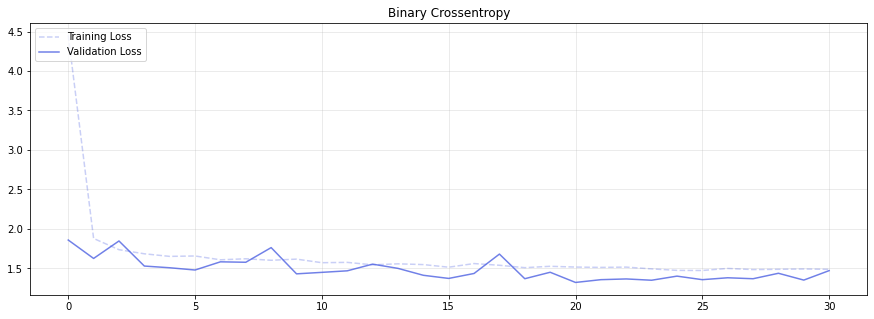

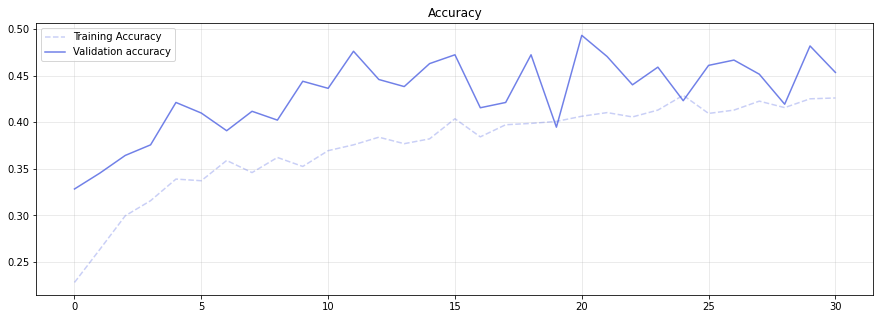

In [18]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [19]:
tl_model.save('Vgg16/FineFineTuning_v1')

In [20]:
tl_model = tfk.models.load_model('Vgg16/FineFineTuning_v1')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [21]:
tl_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [22]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:15]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0       

In [23]:
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [24]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen ,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=2 , restore_best_weights=True)],
    #class_weight = class_weight
).history

Epoch 1/200
175/175 [==============================] - 31s 162ms/step - loss: 1.5348 - accuracy: 0.4136 - precision_1: 0.6034 - recall_1: 0.1818 - val_loss: 1.4112 - val_accuracy: 0.5066 - val_precision_1: 0.6426 - val_recall_1: 0.4061
Epoch 2/200
175/175 [==============================] - 27s 153ms/step - loss: 1.4033 - accuracy: 0.4598 - precision_1: 0.6539 - recall_1: 0.2200 - val_loss: 1.2297 - val_accuracy: 0.5123 - val_precision_1: 0.6357 - val_recall_1: 0.3378
Epoch 3/200
175/175 [==============================] - 28s 158ms/step - loss: 1.2999 - accuracy: 0.4991 - precision_1: 0.6836 - recall_1: 0.2686 - val_loss: 1.5616 - val_accuracy: 0.5332 - val_precision_1: 0.6656 - val_recall_1: 0.3928
Epoch 4/200
175/175 [==============================] - 27s 154ms/step - loss: 1.2353 - accuracy: 0.5263 - precision_1: 0.7092 - recall_1: 0.2975 - val_loss: 1.5997 - val_accuracy: 0.5712 - val_precision_1: 0.6262 - val_recall_1: 0.4991
Epoch 5/200
175/175 [==============================] - 2

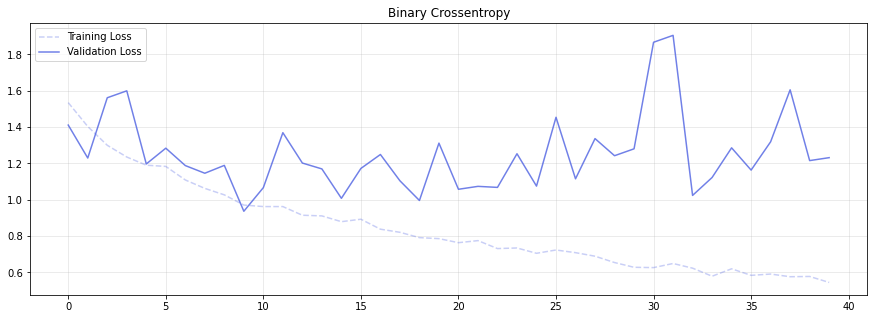

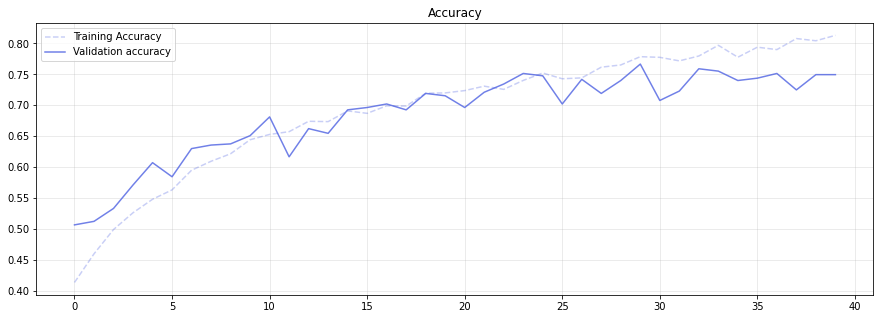

In [25]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [26]:
%cd /gdrive/My Drive/ANDL/Homework_1

/gdrive/My Drive/ANDL/Homework_1


In [27]:
tl_model.save('Vgg16/Tuned_v1_1')

In [28]:
# Test the model
tl_model = tfk.models.load_model("Vgg16/Tuned_v1_1")
model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)

12/12 [==============================] - 72s 7s/step - loss: 1.2691 - accuracy: 0.7313 - precision_1: 0.7605 - recall_1: 0.7036

Test metrics
{'loss': 1.269060492515564, 'accuracy': 0.7313019633293152, 'precision_1': 0.7604790329933167, 'recall_1': 0.7036011219024658}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


Accuracy: 0.7313
Precision: 0.7326
Recall: 0.7054
F1: 0.7126


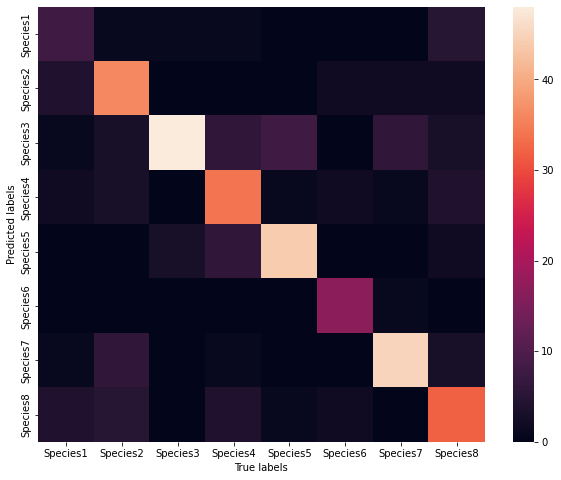

In [29]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()